In [1]:
using PyPlot, LinearAlgebra, Random, Distributions, ForwardDiff
using PyPlot: matplotlib
Random.seed!(2)
rc("axes.spines", top=false, right=false)

In [2]:
function leapfrog(grad::Function, θ::Vector{Float64}, p::Vector{Float64}, ϵ::Float64, L::Int)
    for l in 1:L
        p += 0.5 * ϵ * grad(θ)
        θ += ϵ * p
        p += 0.5 * ϵ * grad(θ)
    end
    return θ, p
end

leapfrog (generic function with 1 method)

In [3]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function HMC(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, L::Int, M::Int)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, M)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:M
        p = randn(d) # get momentum        
        H = -log_p(θ) + 0.5 * p' * p        # initial Hamiltonian
        θ_, p_ = leapfrog(grad, θ, p, ϵ, L) # update
        H_ = -log_p(θ_) + 0.5 * p_' * p_    # final Hamiltonian
        
        if min(1, exp(H - H_)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end

HMC (generic function with 1 method)

In [4]:
function inference_wrapper_HMC(log_joint, params, w_init; maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    ulp(w) = log_joint(w, params...)
    return HMC(ulp, w_init, ϵ, L, maxiter)
end

inference_wrapper_HMC (generic function with 1 method)

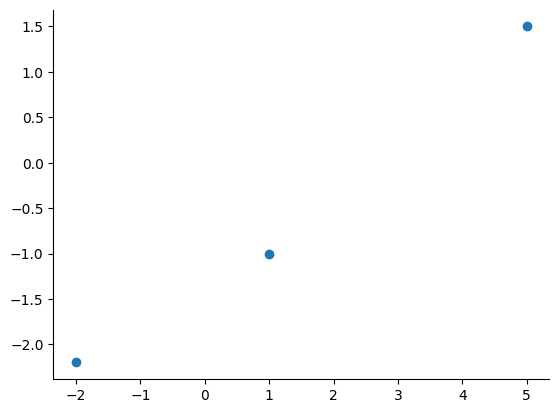

PyObject <matplotlib.collections.PathCollection object at 0x000000010FBBE9A0>

In [5]:
X_obs = [-2, 1, 5]
Y_obs = [-2.2, -1.0, 1.5]

scatter(X_obs, Y_obs)

In [6]:
function log_joint(w, X, Y, σ, μ₁, σ₁, μ₂, σ₂)
    tmp = sum(logpdf.(Normal.(w[1]*X .+ w[2], σ), Y)) 
    tmp += logpdf(Normal(μ₁, σ₁), w[1])
    tmp += logpdf(Normal(μ₂, σ₂), w[2])
    return tmp
end

log_joint (generic function with 1 method)

In [7]:
σ, μ₁, μ₂, σ₁, σ₂ = 1.0, 0.0, 0.0, 10.0, 10.0

(1.0, 0.0, 0.0, 10.0, 10.0)

In [8]:
params = (X_obs, Y_obs, σ, μ₁, σ₁, μ₂, σ₂)

([-2, 1, 5], [-2.2, -1.0, 1.5], 1.0, 0.0, 10.0, 0.0, 10.0)

In [9]:
ulp(w) = log_joint(w, params...)

ulp (generic function with 1 method)

In [10]:
w_init = randn(2)
max_iter = 300

param_posterior, num_accepted = inference_wrapper_HMC(log_joint, params, w_init, maxiter=max_iter, L=10, ϵ=1e-1)

([0.49573512547752774 0.593301161098972 … 0.48666196142755414 0.574423032005922; -0.7779959357328139 -2.173788234817768 … -0.7294131862789365 -0.9620676039583196], 296)

In [11]:
size(param_posterior)

(2, 300)

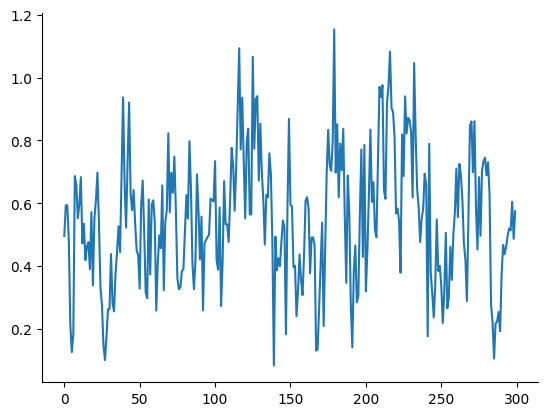

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000010EFE4E20>

In [12]:
plot(param_posterior[1, :])

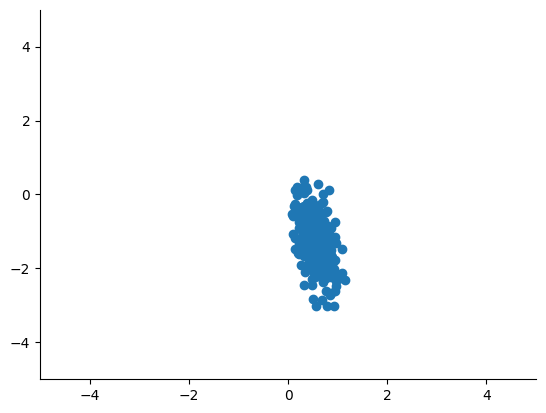

(-5.0, 5.0)

In [13]:
scatter(param_posterior[1, :], param_posterior[2, :])
xlim(-5,5)
ylim(-5,5)